In [14]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
response = requests.get("https://www.footballdb.com/seasons/super-bowls.html", headers = headers)

In [16]:
response.status_code

200

In [17]:
soup = BeautifulSoup(response.text)

In [18]:
df_main = pd.DataFrame()

for ind, table in enumerate(soup.find_all("table"), start = -1 * len(soup.find_all("table"))):
    df = []
    cols = []
    
    for th in table.find_all('th'):
        col = th.text
        if not col.strip():
            col = "Team"
        cols.append(col)
    
    for ind2, tr in enumerate(table.find_all("tr")):
        row = []
        for ind3, td in enumerate(tr.find_all('td')):
            row.append(td.text)
        df.append(row)

        
    df = pd.DataFrame(df, columns = cols)
    df_main = pd.concat([df_main, df])

In [19]:
df_main = df_main.dropna(subset=['1st'])
df_main

,Team,1st,2nd,3rd,4th,Final,OT
1,"Kansas City Chiefs (AFC, 14-2)KC (AFC)",3,3,3,0,9,NaN
2,"Tampa Bay Buccaneers (NFC, 11-5)TB (NFC)",7,14,10,0,31,NaN
1,"San Francisco 49ers (NFC, 13-3)SF (NFC)",3,7,10,0,20,NaN
2,"Kansas City Chiefs (AFC, 12-4)KC (AFC)",7,3,0,21,31,NaN
1,"New England Patriots (AFC, 11-5)NE (AFC)",0,3,0,10,13,NaN
...,...,...,...,...,...,...,...
2,"Baltimore Colts (NFL, 13-1)BAL (NFL)",0,0,0,7,7,NaN
1,"Green Bay Packers (NFL, 9-4-1)GB (NFL)",3,13,10,7,33,NaN
2,"Oakland Raiders (AFL, 13-1)OAK (AFL)",0,7,0,7,14,NaN
1,"Kansas City Chiefs (AFL, 11-2-1)KC (AFL)",0,10,0,0,10,NaN


In [20]:
df_main['Team Name'] = df_main['Team'].str.split("(").str[0]
df_main['Conference'] = [re.findall('\((.*?)\)',s)[-1] for s in df_main['Team']]
df_main

,Team,1st,2nd,3rd,4th,Final,OT,Team Name,Conference
1,"Kansas City Chiefs (AFC, 14-2)KC (AFC)",3,3,3,0,9,NaN,Kansas City Chiefs,AFC
2,"Tampa Bay Buccaneers (NFC, 11-5)TB (NFC)",7,14,10,0,31,NaN,Tampa Bay Buccaneers,NFC
1,"San Francisco 49ers (NFC, 13-3)SF (NFC)",3,7,10,0,20,NaN,San Francisco 49ers,NFC
2,"Kansas City Chiefs (AFC, 12-4)KC (AFC)",7,3,0,21,31,NaN,Kansas City Chiefs,AFC
1,"New England Patriots (AFC, 11-5)NE (AFC)",0,3,0,10,13,NaN,New England Patriots,AFC
...,...,...,...,...,...,...,...,...,...
2,"Baltimore Colts (NFL, 13-1)BAL (NFL)",0,0,0,7,7,NaN,Baltimore Colts,NFL
1,"Green Bay Packers (NFL, 9-4-1)GB (NFL)",3,13,10,7,33,NaN,Green Bay Packers,NFL
2,"Oakland Raiders (AFL, 13-1)OAK (AFL)",0,7,0,7,14,NaN,Oakland Raiders,AFL
1,"Kansas City Chiefs (AFL, 11-2-1)KC (AFL)",0,10,0,0,10,NaN,Kansas City Chiefs,AFL


In [21]:
df_main['2nd'] = df_main['1st'].astype(int) + df_main['2nd'].astype(int)
df_main['3rd'] = df_main['2nd'].astype(int) + df_main['3rd'].astype(int)
df_main['4th'] = df_main['3rd'].astype(int) + df_main['4th'].astype(int)

In [22]:
afc = df_main[df_main['Conference'].str.contains('AF')].reset_index(drop=True)
nfc = df_main[df_main['Conference'].str.contains('NF')].reset_index(drop=True)

df = pd.concat([afc, nfc], axis =1)


In [23]:
df.columns = ['AFC Team', 'AFC 1st', 'AFC 2nd', 'AFC 3rd', 'AFC 4th', 'AFC Final', 'AFC OT', 'AFC Team Name',
       'AFC Conference', 'NFC Team', 'NFC 1st', 'NFC 2nd', 'NFC 3rd', 'NFC 4th', 'NFC Final', 'NFC OT',
       'NFC Team Name', 'NFC Conference']
df['counter'] = 1

df['AFC_Q1_score'] = df['AFC 1st'].astype(str).str[-1]
df['AFC_Q2_score'] = df['AFC 2nd'].astype(str).str[-1]
df['AFC_Q3_score'] = df['AFC 3rd'].astype(str).str[-1]
df['AFC_Q4_score'] = df['AFC Final'].astype(str).str[-1]

df['NFC_Q1_score'] = df['NFC 1st'].astype(str).str[-1]
df['NFC_Q2_score'] = df['NFC 2nd'].astype(str).str[-1]
df['NFC_Q3_score'] = df['NFC 3rd'].astype(str).str[-1]
df['NFC_Q4_score'] = df['NFC Final'].astype(str).str[-1]

In [24]:
def afc_nfc_score_counts(df, afc_scores, nfc_scores):
    return (df
            .groupby(
            [afc_scores, nfc_scores], 
            as_index=False)
            ['counter']
            .count()
            .pivot_table(values = 'counter', 
                         columns = afc_scores, 
                         index= nfc_scores)
            .reindex([str(i) for i in range(0,10)])
            .T
            .reindex([str(i) for i in range(0,10)])
            .T
            .replace(np.nan, 0)
            .astype(int)
            .values
           )

In [25]:
q1 = afc_nfc_score_counts(df, 'AFC_Q1_score', 'NFC_Q1_score')
q2 = afc_nfc_score_counts(df, 'AFC_Q2_score', 'NFC_Q2_score')
q3 = afc_nfc_score_counts(df, 'AFC_Q3_score', 'NFC_Q3_score')
q4 = afc_nfc_score_counts(df, 'AFC_Q4_score', 'NFC_Q4_score')

Text(123.0, 0.5, 'NFC')

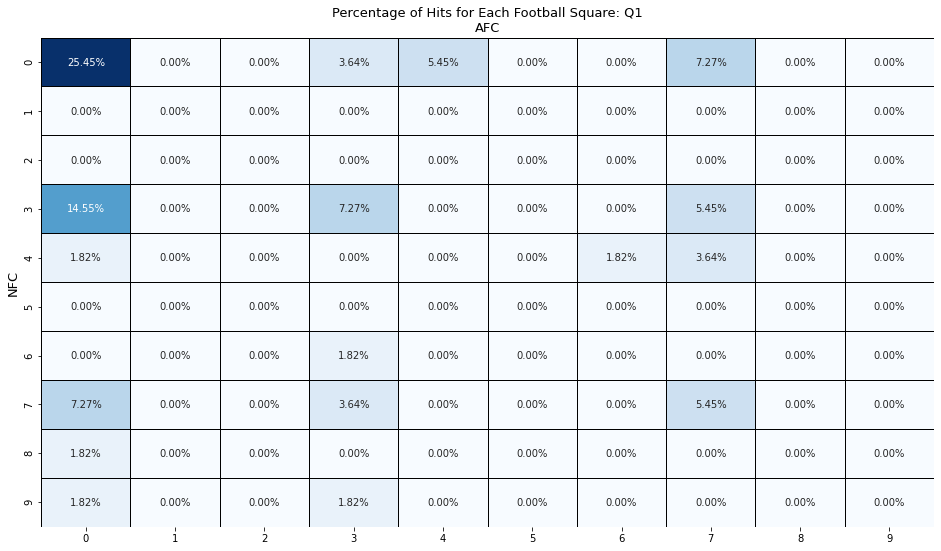

In [41]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(pd.DataFrame((q1)/sum(sum(q1))), 
            cmap = "Blues", 
            annot = True,  
            fmt=".2%", 
            ax = ax, 
            cbar = None, 
            linewidths= 1, 
            linecolor = 'black')

plt.title('Percentage of Hits for Each Football Square: Q1\nAFC', fontsize=13) 
plt.ylabel('NFC', fontsize = 13) 


Text(123.0, 0.5, 'NFC')

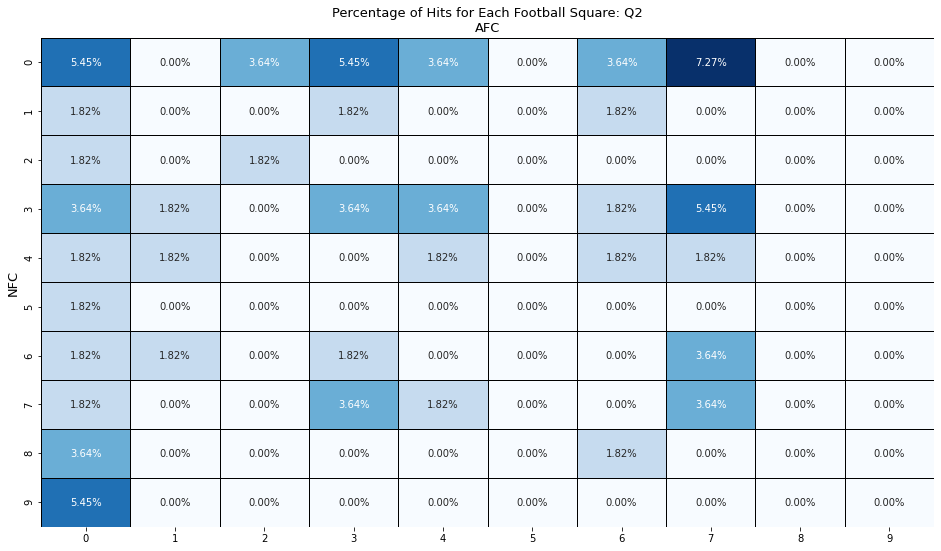

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(pd.DataFrame((q2)/sum(sum(q2))), 
            cmap = "Blues", 
            annot = True,  
            fmt=".2%", 
            ax = ax, 
            cbar = None, 
            linewidths= 1, 
            linecolor = 'black')

plt.title('Percentage of Hits for Each Football Square: Q2\nAFC', fontsize=13) 
plt.ylabel('NFC', fontsize = 13) 


Text(123.0, 0.5, 'NFC')

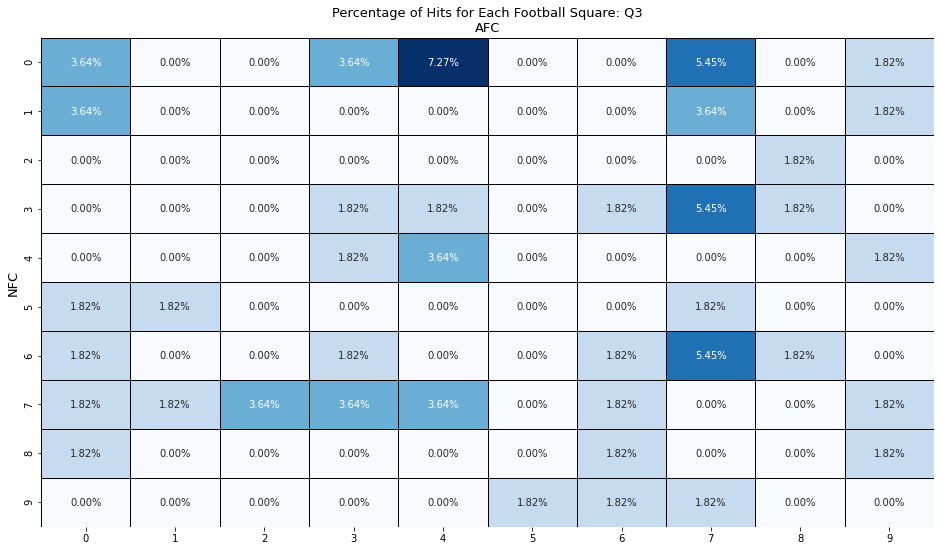

In [39]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(pd.DataFrame((q3)/sum(sum(q3))), 
            cmap = "Blues", 
            annot = True,  
            fmt=".2%", 
            ax = ax, 
            cbar = None, 
            linewidths= 1, 
            linecolor = 'black')

plt.title('Percentage of Hits for Each Football Square: Q3\nAFC', fontsize=13) 
plt.ylabel('NFC', fontsize = 13) 


Text(123.0, 0.5, 'NFC')

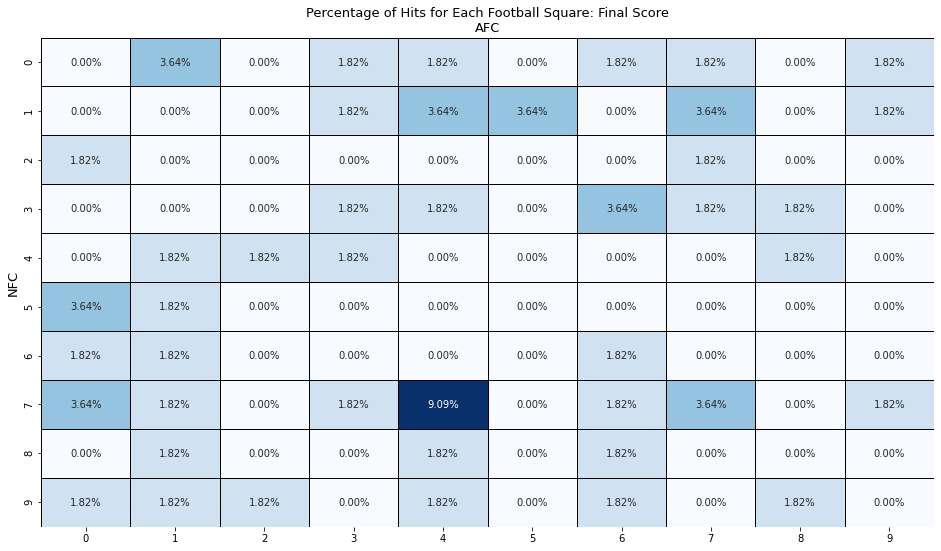

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(pd.DataFrame((q4)/sum(sum(q4))), 
            cmap = "Blues", 
            annot = True,  
            fmt=".2%", 
            ax = ax, 
            cbar = None, 
            linewidths= 1, 
            linecolor = 'black')

plt.title('Percentage of Hits for Each Football Square: Final Score\nAFC', fontsize=13) 
plt.ylabel('NFC', fontsize = 13) 


Text(123.0, 0.5, 'NFC')

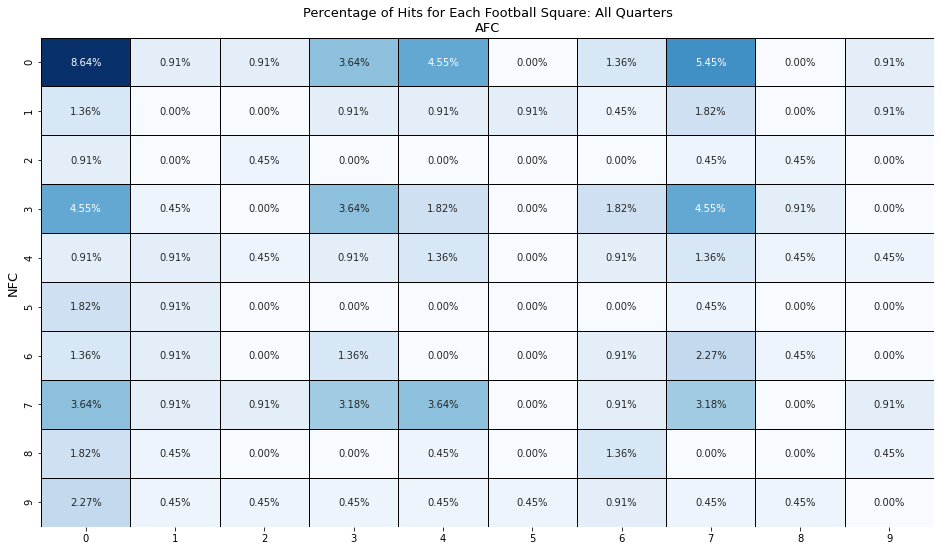

In [45]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(pd.DataFrame((q1 + q2 + q3 + q4)/sum(sum(q1 + q2 + q3 + q4))), 
            cmap = "Blues", 
            annot = True,  
            fmt=".2%", 
            ax = ax, 
            cbar = None, 
            linewidths= 1, 
            linecolor = 'black')

plt.title('Percentage of Hits for Each Football Square: All Quarters\nAFC', fontsize=13) 
plt.ylabel('NFC', fontsize = 13) 
